# Inspecting atlas shipped in BrainLM

The original data processing code of BrainLM extract time sereis using A424 atlas in an unidentified MNI152 template in 2mm space. 

There were no sainty check to make sure all the functional data and the atlas are in the same space.
Hence for the purpose of running the BrainLM tutorial using the nilearn test dataset developmental dataset, and using as much of the original code as possible, we need to manually resample the atlas to match the nilearn developmental dataset.

In [1]:
from nilearn import plotting, image
import nibabel as nib
from nilearn.maskers import NiftiLabelsMasker, NiftiSpheresMasker, NiftiMasker, NiftiMapsMasker
from nilearn.datasets import MNI152_FILE_PATH, load_mni152_gm_mask, fetch_atlas_difumo, fetch_icbm152_2009
from importlib.resources import files
import numpy as np
from hfplayground.data import downsample_for_tutorial
from pathlib import Path
from datasets import load_from_disk


In [2]:
downsample_atlas = downsample_for_tutorial(files('hfplayground') / 'data/brainlm/atlases/A424+2mm.nii.gz', '/tmp/')
downsample_mni = downsample_for_tutorial(MNI152_FILE_PATH, '/tmp/')

The original A424 atlas is very strictly following the grey matter, and includes the cerebellum. 
The inclusion of cerebellum is going to become an issue as in a lot of datasets, cereberllum coverage is poor.
This is a known issue in the developmental dataset.

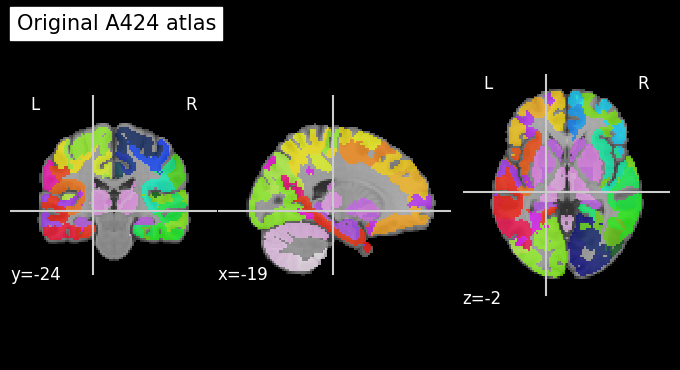

In [3]:
plotting.plot_roi(files('hfplayground') / 'data/brainlm/atlases/A424+4mm.nii.gz', title="Original A424 atlas", black_bg=True)

The nilearn test dataset has been downsampled to voxel size 4mm^3, so we have to resample the atlas accordingly. 

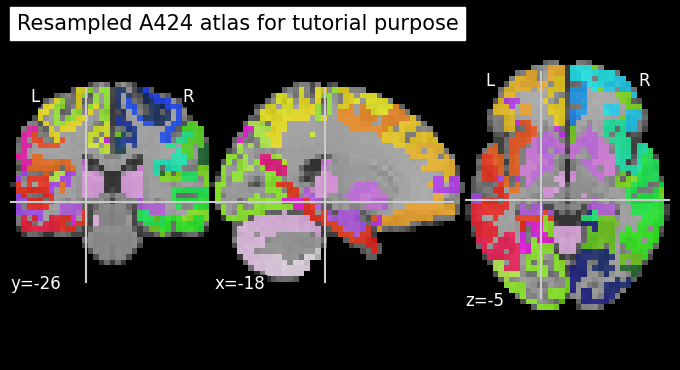

In [4]:
plotting.plot_roi(downsample_atlas, downsample_mni, title="Resampled A424 atlas for tutorial purpose")

Let's overlay it on real data. 

We can see that the cerebellum is cut off in the EPI scan. This is a very common compromise. 
BrainLM default workflow for data preperation is to pad zeros in the data.

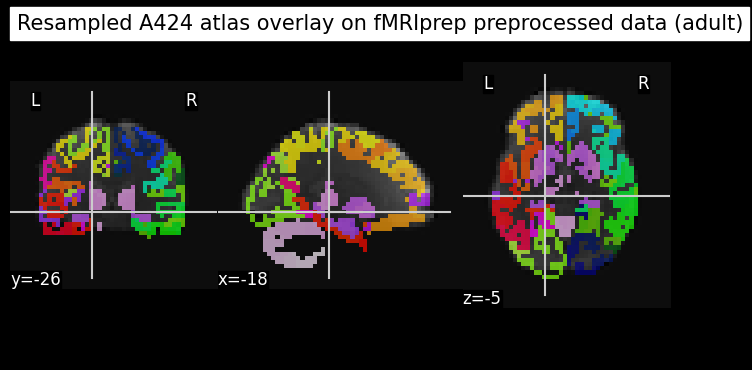

In [5]:
bg_img = image.load_img('../data/external/development_fmri/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
plotting.plot_roi(downsample_atlas, bg_img=bg_img.slicer[..., 0], title="Resampled A424 atlas overlay on fMRIprep preprocessed data (adult)")

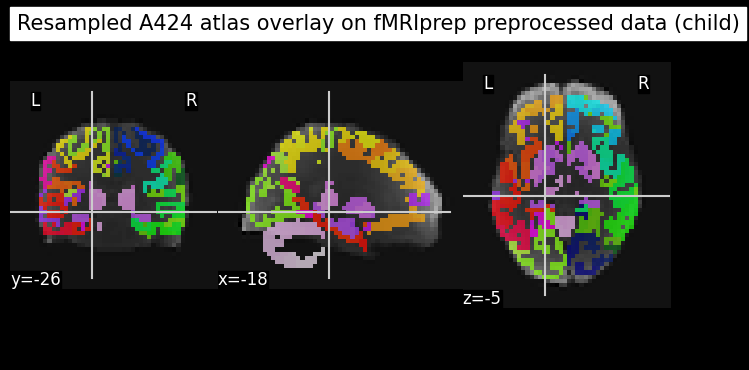

In [6]:
bg_img = image.load_img('../data/external/development_fmri/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz')
plotting.plot_roi(downsample_atlas, bg_img=bg_img.slicer[..., 0], title="Resampled A424 atlas overlay on fMRIprep preprocessed data (child)")

Overlaying on data after denoising. Since I used a MNI template brain mask, we can see the missing cerebellum is filled up. 

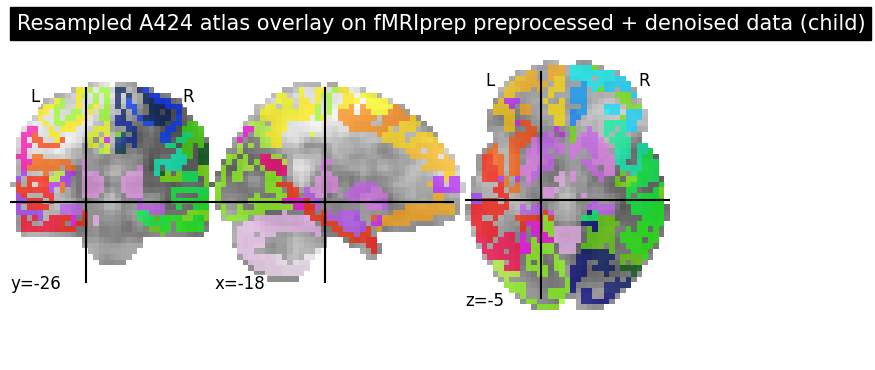

In [7]:
bg_img = image.load_img('../data/interim/development_fmri/sub-pixar001_task-pixar_space-MNI152NLin2009cAsym_desc-simple+gsr_bold.nii.gz')
plotting.plot_roi(downsample_atlas, bg_img=bg_img.slicer[..., 0], title="Resampled A424 atlas overlay on fMRIprep preprocessed + denoised data (child)")

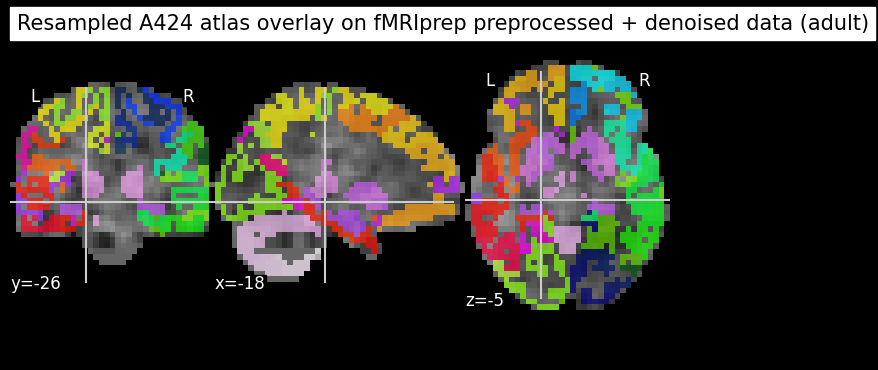

In [8]:
bg_img = image.load_img('../data/interim/development_fmri/sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-simple+gsr_bold.nii.gz')
plotting.plot_roi(downsample_atlas, bg_img=bg_img.slicer[..., 0], title="Resampled A424 atlas overlay on fMRIprep preprocessed + denoised data (adult)")

Once we have some preprocessed time series, using their workflow, let's have a look at the results.

The fMRIPrep data here is preprocessed with FWHM 8mm, standardization at per voxel level, and denoise with the simple strategy of load_confounds, with cosine regressors, 6 motion parameters, white matter/csf followed by some very sus workflow provided with the code to extract time sereis from the ROIs.

These outputs are hugging face / arrow datasets. For the brain region coordinates, each entry is a brain region with it's index, and corrdinate of the centroid.

For the time series data, each subject is an entry:
- Raw_Recording
- Voxelwise_RobustScaler_Normalized_Recording
- All_Patient_All_Voxel_Normalized_Recording
- Per_Patient_All_Voxel_Normalized_Recording
- Per_Patient_Per_Voxel_Normalized_Recording
- Per_Voxel_All_Patient_Normalized_Recording
- Subtract_Mean_Normalized_Recording
- Subtract_Mean_Divide_Global_STD_Normalized_Recording
- Subtract_Mean_Divide_Global_99thPercent_Normalized_Recording
- Filename
- Patient ID: totally failed at parsing this, no value

The dimension of the time series should be number of time points x  number of parcels

I am going to use seed base connectivity using the PCC as a way to do some sanity check.
With a quick search in the script, it seems there are multiple scaling strategy that has been tested at some point.

Manually found a PCC ish coordinate.

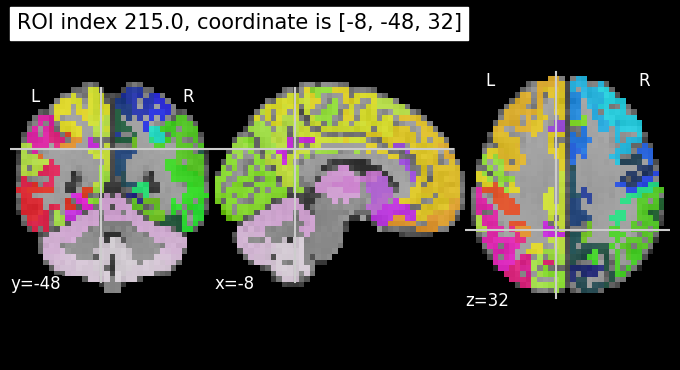

In [9]:
coords_ds = load_from_disk("../data/processed/development_fmri_brainlm_a424/brainregion_coordinates.arrow")

roi_index = 215  # this is index saved in file, so 1-based
coord = [int(coords_ds[roi_index - 1][k]) for i, k in enumerate(coords_ds[roi_index - 1]) if i != 0]
plotting.plot_roi(
    downsample_atlas, 
    bg_img=downsample_mni, 
    title=f"ROI index {coords_ds[roi_index - 1]['Index']}, coordinate is {coord}", 
    cut_coords=coord)

Create seed base connectivity map as a base of comparison for all scaled data by BrainLM workflow.
Also use DiFuMo to see what it looks like on an atlas with good signal reconstruction.

In [10]:
get_seed = NiftiSpheresMasker(seeds=[coord], radius=8).fit()
mni_mask = nib.save(load_mni152_gm_mask(), Path('/tmp/mni_mask.nii.gz'))
mni_mask = downsample_for_tutorial(Path('/tmp/mni_mask.nii.gz'), '/tmp/')
mni_masker = NiftiMasker(mni_mask, target_affine=bg_img.affine, target_shape=bg_img.shape[:3]).fit()
difumo_pcc = 142
difumo_masker = NiftiMapsMasker(fetch_atlas_difumo(dimension=512, resolution_mm=3).maps)

nii_seedbased = {}
nii_difumo = {}

for label, id in zip(['adult', 'child'], [123, 1]):
    filename = f'sub-pixar{id:03d}_task-pixar_space-MNI152NLin2009cAsym_desc-simple+gsr_bold.nii.gz'
    nii_path = f"../data/interim/development_fmri/{filename}"
    ts = get_seed.transform(nii_path)
    voxels = mni_masker.transform(nii_path)
    seed_base_connectivity = np.corrcoef(ts.T, voxels.T)[1:, 0]
    seed_base_nii = mni_masker.inverse_transform(seed_base_connectivity)
    nii_seedbased[label] = seed_base_nii

    difumo_ts = difumo_masker.fit_transform(nii_path)
    seed_base_connectivity = np.corrcoef(difumo_ts.T)[difumo_pcc - 1]
    nii = difumo_masker.inverse_transform(seed_base_connectivity)
    nii_difumo[label] = nii


[get_dataset_dir] Dataset found in /home/hwang/nilearn_data/difumo_atlases
[NiftiMasker.wrapped] Resampling images


/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


[NiftiMasker.wrapped] Resampling images


/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/nilearn/plotting/img_plotting.py:1416: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


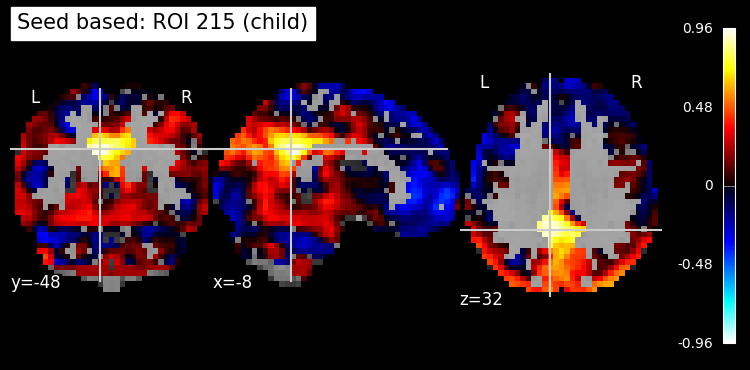

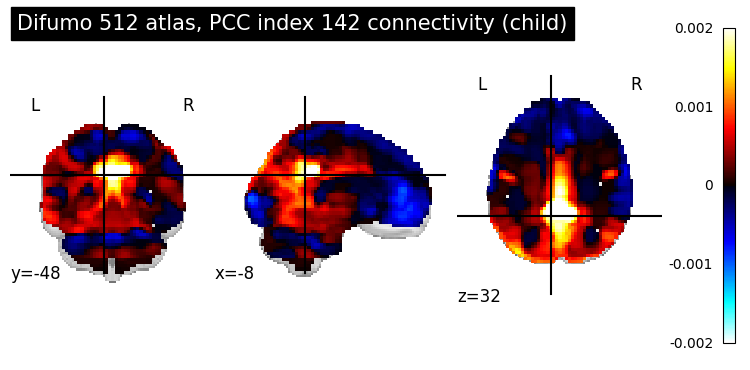

In [11]:
plotting.plot_stat_map(nii_seedbased[label] , 
    threshold=0.01, cut_coords=coord, bg_img=downsample_mni, 
    black_bg=True, colorbar=True,
    title=f"Seed based: ROI {roi_index} ({label})"
)

plotting.plot_stat_map(
    nii_difumo[label], vmin=-0.002, vmax=0.002, colorbar=True,
    cut_coords=coord,
    title=f"Difumo 512 atlas, PCC index {difumo_pcc} connectivity ({label})"
)

[get_dataset_dir] Dataset found in /home/hwang/nilearn_data/icbm152_2009


/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/nilearn/plotting/img_plotting.py:1416: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),
/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/hwang/simexp/hwang/hfplayground/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


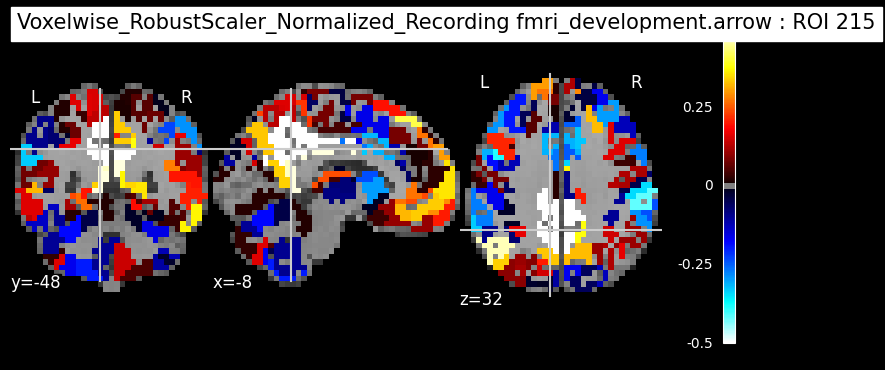

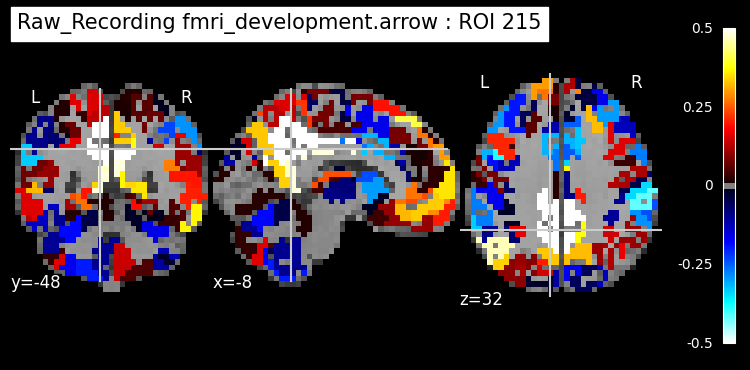

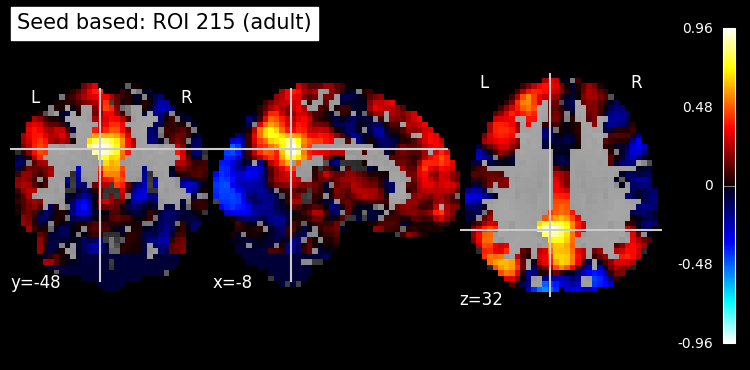

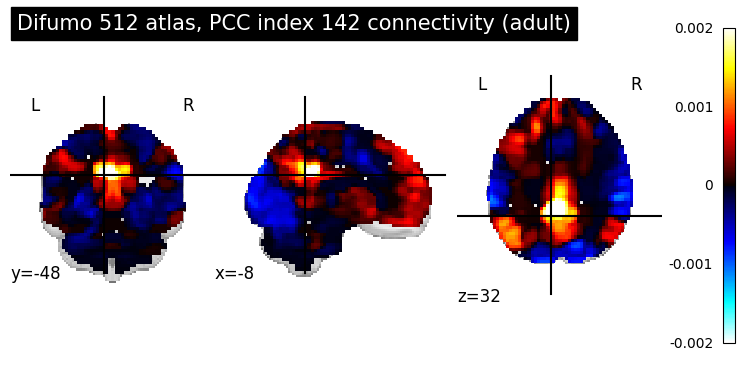

In [12]:
mni_mask = fetch_icbm152_2009()['mask']
mni_mask = downsample_for_tutorial(mni_mask, '/tmp/')
atlas_masker = NiftiLabelsMasker(
    labels_img=files('hfplayground') / 'data/development_fmri/downsample_A424+2mm.nii.gz',
    mask_img=mni_mask
).fit()  # use the prepared atlas rather than the demo

arrow_path = Path("../data/processed/development_fmri_brainlm_a424/fmri_development.arrow")
ds = load_from_disk(arrow_path)
prepro_method = arrow_path.name.split("development_fmri_")[-1].split("_a424")[0]
for i, subject in enumerate(ds):
    if "sub-123_" in subject['Filename']:
        break
for key in ['Voxelwise_RobustScaler_Normalized_Recording', 'Raw_Recording']:
    if "Recording" not in key:
        continue
    seed_base_connectivity = np.corrcoef(np.array(ds[i][key]).T)[roi_index - 1]
    nii = atlas_masker.inverse_transform(seed_base_connectivity)
    plotting.plot_stat_map(
        nii, vmin=-0.5, vmax=0.5, threshold=0.01,  colorbar=True,
        cut_coords=coord, bg_img=downsample_mni,
        title=f"{key} {prepro_method} : ROI {roi_index}"
    )

label = 'adult'
plotting.plot_stat_map(nii_seedbased[label] , 
    threshold=0.01, cut_coords=coord, bg_img=downsample_mni, 
    black_bg=True, colorbar=True,
    title=f"Seed based: ROI {roi_index} ({label})"
)
plotting.plot_stat_map(
    nii_difumo[label], vmin=-0.002, vmax=0.002, colorbar=True,
    cut_coords=coord,
    title=f"Difumo 512 atlas, PCC index {difumo_pcc} connectivity ({label})"
)

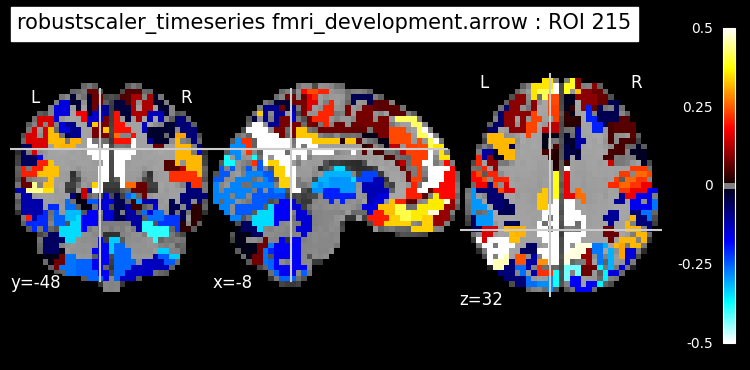

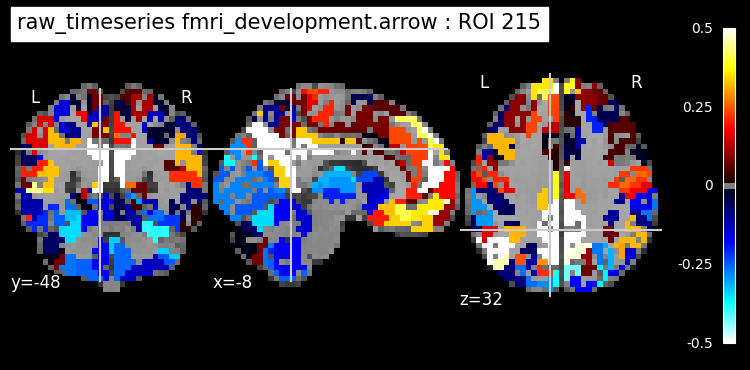

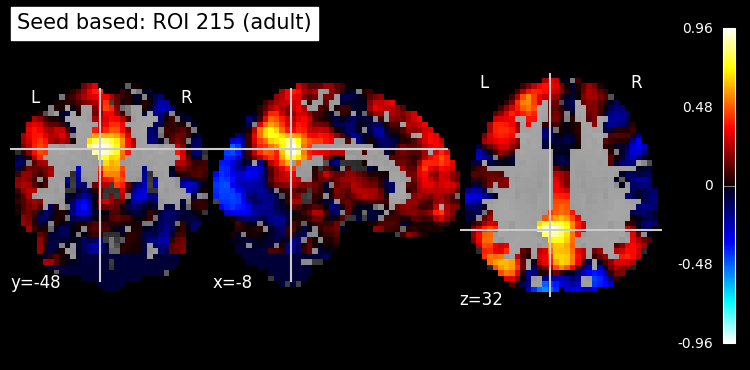

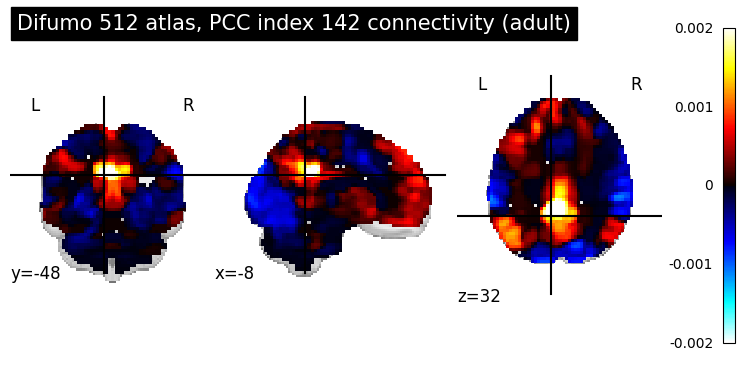

In [13]:

arrow_path = Path("../data/processed/development_fmri_gigaconnectome_a424/fmri_development.arrow")
ds = load_from_disk(arrow_path)
prepro_method = arrow_path.name.split("development_fmri_")[-1].split("_a424")[0]
for i, subject in enumerate(ds):
    if "sub-123" == subject['participant_id']:
        break

figure_gigaconnectome = {}
for key in ds[i].keys():
    if "timeseries" not in key:
        continue
    seed_base_connectivity = np.corrcoef(np.array(ds[i][key]).T)[roi_index - 1]
    nii = atlas_masker.inverse_transform(seed_base_connectivity)
    figure_gigaconnectome[key] = plotting.plot_stat_map(
        nii, vmin=-0.5, vmax=0.5, threshold=0.01, colorbar=True,
        cut_coords=coord, bg_img=downsample_mni,
        title=f"{key} {prepro_method} : ROI {roi_index}",
    )

label = 'adult'
plotting.plot_stat_map(nii_seedbased[label] , 
    threshold=0.01, cut_coords=coord, bg_img=downsample_mni, 
    black_bg=True, colorbar=True,
    title=f"Seed based: ROI {roi_index} ({label})"
)
plotting.plot_stat_map(
    nii_difumo[label], vmin=-0.002, vmax=0.002, colorbar=True,
    cut_coords=coord,
    title=f"Difumo 512 atlas, PCC index {difumo_pcc} connectivity ({label})"
)

# Conclusion

The various scaling done in the BrainLM workflow will produce drasically different results if the preprocessed data did not have any kind of scaling per voxel.
It is unclear why they still tested so many different approaches as in the documentation it seems they did apply normalisation (assuming this is normalisation per voxel) in the UKBB data (the training data for the pretrain model.)

We can use the giga connectome output without the scaling workflow safely.

In BrainLM workflow, they replace nan in timeseries with 0.
